In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


In [2]:
import wandb
import inspect
import seaborn as sns
import pandas as pd
import json
from tqdm.notebook import tqdm
import os
import yaml


class ResultsManager:
    def __init__(self, wandb_user, wandb_project, dataset_info_file, 
                 style_info_file, sid_info_file, verbose=False):
        self.api = wandb.Api()
        self.verbose = verbose
        self.wandb_user = wandb_user
        self.wandb_project = wandb_project
        
        with open(dataset_info_file, 'r') as stream:
            self.datasets_info = yaml.safe_load(stream)
    
        with open(sid_info_file,'r') as stream:
            self.sid_info = yaml.safe_load(stream)

        self.algorithms = ['IRM','ERM','ECI', 'ECI', 'EI','VIB']
            
        with open(style_info_file,'r') as stream:
            self.style_info = yaml.safe_load(stream)
        
        if verbose:
            print('User: %s' % wandb_user)
            print('Project: %s' % wandb_project)
            print('Algorithms: %s' % str(list(self.algorithms)))
            print('Datasets: %s' % str(list(self.datasets_info.keys())))
            
    def sid2sweep(self, sid):
        return self.api.sweep('%s/%s'%(self.wandb_project, sid))
    
    def rid2datalg(self, rid):
        run = self.api.run('%s/%s'%(self.wandb_project, rid))
        return self.sid2datalg(run.sweep.id)
    
    def get_name(self, idx):
        if idx in self.style_info:
            if 'name' in self.style_info[idx]:
                return self.style_info[idx]['name']
            else:
                return idx
            
    def datalg2uid(self, dataset, algorithm):
        return dataset+'-'+algorithm
    
    def sid2datalg(self, sid):
        uids = [uid for uid in self.sid_info if sid in self.sid_info[uid]['sid']]
        assert len(uids) == 1
        return self.uid2datalg(uids[0])

    def uid2datalg(self, uid):
        datalg = uid.split('-')
        return datalg[0], datalg[1]

    def get_sweep(self, dataset, algorithm):
        name = self.datalg2uid(dataset, algorithm)
        sid = self.sid_info[name]['id']
        return self.sid2sweep(sid)
    
    def get_runs(self, dataset, algorithm):
        name = self.datalg2uid(dataset, algorithm)
        sid = self.sid_info[name]['sid']
        if not isinstance(sid, list):
            sid = [sid]
            
        runs = []
        for s in sid:
            runs += self.sid2sweep(s).runs
        return runs
    
    def get_algorithms(self, dataset=None):
        if dataset:
            return [alg for alg in self.algorithms 
                    if self.datalg2uid(dataset,alg) in self.sid_info]
        else:
            return [alg for alg in self.algorithms.keys()]
        
    def get_run_config(self, run):
        dataset, algorithm = self.sid2datalg(run.sweep.id)
        key_lookup = self.algorithms_info[algorithm]['params']
        return {key: run.config[value['config_key']] for key,value in key_lookup.items()}
    

if 'WANDB_USER' in os.environ:
    wandb_user = os.environ['WANDB_USER']
else:
    raise Exception('Please set WANDB_USER')
    
if 'WANDB_PROJECT' in os.environ:
    wandb_project = os.environ['WANDB_PROJECT']
else:
    raise Exception('Please set WANDB_PROJECT')

    
rm = ResultsManager(wandb_user=wandb_user, 
                    wandb_project=wandb_project, 
                    dataset_info_file='results/datasets.yml', 
                    sid_info_file='results/ids.yml',
                    style_info_file='results/styles.yml',
                    verbose=True)


User: mfederici
Project: causal-mib
Algorithms: ['IRM', 'ERM', 'ECI', 'ECI', 'EI', 'VIB']
Datasets: ['D_CMNIST', 'D_CMNIST_v2', 'D_CMNIST_v3']


In [3]:
def decorate_plot(dataset_config, style_info, ax, plot_only=None):
    for name, point in dataset_config['plot'].items():
        if 'name' in style_info[name]:
            label = style_info[name]['name']
        else:
            label = name
        
        plot_this = plot_only is None
        if not plot_this:
            plot_this = name in plot_only
        
        if plot_this:
            ax.plot(point['coord'][0], point['coord'][1], label='$%s$'%label, **style_info[name]['params'])
        else:
            print('Not printing: %s'%name)

    ax.set_xlim(*dataset_config['lims']['x'])
    ax.set_ylim(*dataset_config['lims']['y'])

    ax.set_xlabel('$\\mathbb{E}_{t=0}[-\\log\\ q_\\theta(y|x)]$', size=15)
    ax.set_ylabel('$\\mathbb{E}_{t=1}[-\\log\\ q_\\theta(y|x)]$', size=15)
    

In [4]:


def plot_data(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    points = []
    for data in all_data:
        mu = np.mean(data, axis=0)
        sigma = np.cov(data, rowvar=0)

        U, s, _ = numpy.linalg.svd(sigma)

        ax.plot(mu[0],mu[1],'.', color=color)
        ax.plot([mu[0]-U[0,0]*s[0]**0.5,mu[0]+U[0,0]*s[0]**0.5],[mu[1]-U[0,1]*s[0]**0.5,mu[1]+U[0,1]*s[0]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        ax.plot([mu[0]-U[1,0]*s[1]**0.5,mu[0]+U[1,0]*s[1]**0.5],[mu[1]-U[1,1]*s[1]**0.5,mu[1]+U[1,1]*s[1]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        points.append(mu.reshape(1,-1))
    points = np.concatenate(points,0)
    ax.plot(points[:,0], points[:,1], color=color, label=label)    
    
    
def plot_data_points(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    all_data = pd.concat(all_data)
    
    x_min, x_max = all_data['train'].min(),all_data['train'].max()
    
    n = 3  # degree of polynomial
    p, C_p = np.polyfit(all_data['train'], all_data['test'], n, cov=True)  # C_z is estimated covariance matrix

    # Do the interpolation for plotting:
    t = np.linspace(x_min, x_max, 100)
    # Matrix with rows 1, t, t**2, ...:
    TT = np.vstack([t**(n-i) for i in range(n+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    # Do the plotting:
    ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25, color=color) 
    ax.plot(t, yi,'-', color=color, label=label) 
    ax.plot(all_data['train'],all_data['test'],'.',color=color, alpha=0.1) 


def plot_sweep_result(runs, get_last_run_data, sortkey, ax, uncertainty_alpha=0.5, color=None, label=None, consider_last=1000):
    points = []
    reg_strenght = []
    all_data = [get_last_run_data(run, consider_last=consider_last) for run in runs]
    #sortby = [json.loads(run.json_config)[sortkey]['value'] for run in sweep.runs]
    #order = np.argsort(sortby)
    
    #print(order)
    if len(all_data)>0:
        plot_data_points(all_data, ax, color=color, uncertainty_alpha=uncertainty_alpha, label=label)





In [5]:
def get_last_mixed_data(run, consider_last=None, samples=None):
        if consider_last is None:
            h = run.history(samples=samples, pandas=False)
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':(r['test_ce_01']+r['test_ce_02'])/2.0, 
                        'test':r['test_ce_09'],
                        'step': r['_step']} for r in h if 'test_ce_01' in r]
        return pd.DataFrame(data)
    
def get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['train_ce'], 
                 'test':r['test_ce'],
                 'step': r['_step']} for r in h if 'test_ce' in r]
        return pd.DataFrame(data)
    
def sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['train_ce'], 
             'test':r['test_ce'],
             'step': r['_step']} for r in h if 'test_ce' in r]
    return pd.DataFrame(data)

    
def _get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['CE(train_t0)'], 
                 'test':r['CE(test_t1)'],
                 'step': r['_step']} for r in h if 'CE(test_t1)' in r]
        return pd.DataFrame(data)
    
def _sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['CE(train_t0)'], 
             'test':r['CE(test_t1)'],
             'step': r['_step']} for r in h if 'CE(test_t1)' in r]
    return pd.DataFrame(data)

process_run = {
    'D_CMNIST': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'D_CMNIST_v2': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'D_CMNIST_v3': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'SpeechCommands': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data,
    }
    
}

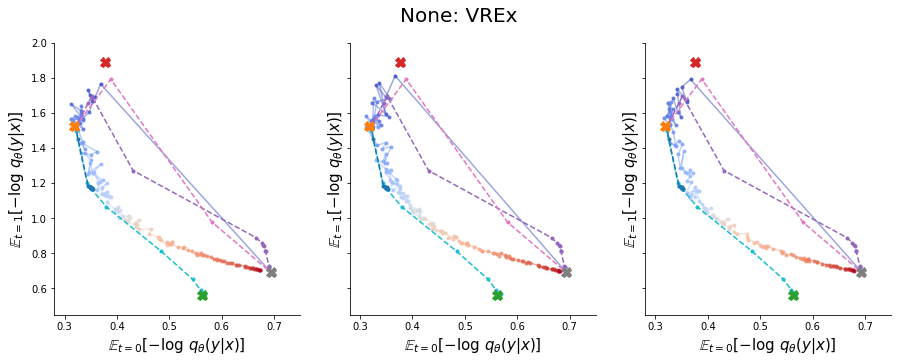

In [243]:
dataset = 'D_CMNIST_v2'
algorithm = 'VREx'

min_step = 0
max_step = 30000

runs = rm.get_runs(dataset=dataset, algorithm=algorithm)

cmap = plt.get_cmap('coolwarm')

f, ax = plt.subplots(1,len(runs), figsize=(5*len(runs),5), sharex=True, sharey=True)
if len(runs)==1:
    ax = [ax]

sns.despine()

f.suptitle('%s: %s'%(rm.get_name(dataset), rm.get_name(algorithm)), size=20)

for j,run in enumerate(tqdm(runs)):
    #config_key = rm.algorithms_info[algorithm]['params']['beta']['config_key']
    #ax[j].set_title('$\\beta$= %f'%(run.config[config_key]))
        
    h = run.scan_history(min_step=min_step, max_step=max_step)
    data = [{'train':r['CE(train_t0)'], 
                 'test':r['CE(test_t1)'],
                 'step': r['_step']} for r in h if 'CE(test_t1)' in r]
    run_data = pd.DataFrame(data)
    #process_run[dataset]['sample'](run,10000)
    colors = np.array([cmap(v/run_data['step'].values.max()) 
                       for v in run_data['step'].values[:len(run_data['step'].values)]])
    
    
    for i in range(len(colors)):
        ax[j].plot(run_data['train'][i], run_data['test'][i],'.',color=colors[i], alpha=0.8)
        ax[j].plot(run_data['train'][i:i+2], run_data['test'][i:i+2],'-',color=colors[i], alpha=0.5)
        
    decorate_plot(rm.datasets_info[dataset], rm.style_info, ax[j])

        

        #ax[j].set_title(run_name, fontsize=20)

#ax[-1].legend(fontsize=12)

In [6]:
x = datasets['train_t0'][31]['x'].permute(1,2,0)
im = torch.cat([x, x[:,:,0].unsqueeze(-1)*0],2).numpy().astype(np.float)
plt.imshow(im[:,:], cmap='bone')
plt.axis('off')

NameError: name 'datasets' is not defined

In [40]:
dataset = 'D_CMNIST_v2'

max_iterations = 35000

recompute = False
arch_filepath = 'definitions/architectures/CMNIST.py'
save_path = 'results/final_eval'

data_filepath = os.path.join(save_path,'runs_%s.yml'%dataset)

from data import *
from eval.accuracy import AccuracyEvaluation, CrossEntropyEvaluation
from utils.run_manager.wandb import WANDBRunManager

datasets = {}

datasets['train_t0'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset))
datasets['train_t1'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset))
datasets['test_t0'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset))
datasets['test_t1'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset))

results = []
ids = []

if os.path.isfile(data_filepath):
    with open(data_filepath, 'r') as file:
        results = yaml.safe_load(file)
    ids = [row['rid'] for row in results]

for algorithm in rm.get_algorithms(dataset):
    runs = rm.get_runs(dataset, algorithm)
    print(algorithm)
    
    for run in tqdm(runs):
        
        
        run_manager = WANDBRunManager(experiments_root='.', arch_filepath=arch_filepath, 
                                      desc=None, run_id=run.id, verbose=False, init=False, resume=False)
        
        try:
            trainer, _ = run_manager.make_instances()
        except Exception as e:
            print(e)
            continue

        evaluators = {}
        for d in datasets:
            evaluators['CE(%s)'% d] = CrossEntropyEvaluation(trainer=trainer, datasets=datasets, evaluate_on=d)

        
        files = [file for file in run.files() if file.name.endswith('.pt')]
        all_models = []
        for file in files:
            if '_' in file.name:
                iteration = int(file.name.split('_')[1].split('.')[0])
                if iteration < max_iterations:
                    all_models.append(file)
        
        for file in tqdm(all_models):
            
            
            iteration = int(file.name.split('_')[1].split('.')[0])
            
            if run.id in ids and not recompute:
                if iteration in [row['iterations'] for row in results if row['rid']==run.id]:
                    print('%s_%d: already computed'%(run.id, iteration))
                    continue
            
            evaluation = {}
            
            run_manager.load_model(trainer, file.name)
            
            for name, evaluator in tqdm(evaluators.items()):
                evaluation[name] = float(evaluator.evaluate()['value'])

            evaluation['rid'] = run.id
            evaluation['iterations'] = iteration
            evaluation['beta'] = trainer.beta_scheduler(self.trainer)
            
            results.append(evaluation)


with open(data_filepath, 'w') as file:
    yaml.dump(results, file)
    
results = pd.DataFrame(results)

ECI


tlavzcqb_0: already computed
tlavzcqb_10681: already computed
tlavzcqb_12818: already computed
tlavzcqb_14954: already computed
tlavzcqb_17090: already computed
tlavzcqb_19227: already computed
tlavzcqb_2136: already computed
tlavzcqb_21363: already computed
tlavzcqb_23500: already computed
tlavzcqb_25636: already computed
tlavzcqb_27772: already computed
tlavzcqb_29909: already computed
tlavzcqb_32045: already computed
tlavzcqb_34181: already computed
tlavzcqb_4272: already computed
tlavzcqb_6409: already computed
tlavzcqb_8545: already computed



yjjc3f49_0: already computed
yjjc3f49_10681: already computed
yjjc3f49_12818: already computed
yjjc3f49_14954: already computed
yjjc3f49_17090: already computed
yjjc3f49_19227: already computed
yjjc3f49_2136: already computed
yjjc3f49_21363: already computed
yjjc3f49_23500: already computed
yjjc3f49_25636: already computed
yjjc3f49_27772: already computed
yjjc3f49_29909: already computed
yjjc3f49_32045: already computed
yjjc3f49_34181: already computed
yjjc3f49_4272: already computed
yjjc3f49_6409: already computed
yjjc3f49_8545: already computed



pp6q6l7x_0: already computed
pp6q6l7x_10681: already computed
pp6q6l7x_12818: already computed
pp6q6l7x_14954: already computed
pp6q6l7x_17090: already computed
pp6q6l7x_19227: already computed
pp6q6l7x_2136: already computed
pp6q6l7x_21363: already computed
pp6q6l7x_23500: already computed
pp6q6l7x_25636: already computed
pp6q6l7x_27772: already computed
pp6q6l7x_29909: already computed
pp6q6l7x_32045: already computed
pp6q6l7x_34181: already computed
pp6q6l7x_4272: already computed
pp6q6l7x_6409: already computed
pp6q6l7x_8545: already computed


ECI


tlavzcqb_0: already computed
tlavzcqb_10681: already computed
tlavzcqb_12818: already computed
tlavzcqb_14954: already computed
tlavzcqb_17090: already computed
tlavzcqb_19227: already computed
tlavzcqb_2136: already computed
tlavzcqb_21363: already computed
tlavzcqb_23500: already computed
tlavzcqb_25636: already computed
tlavzcqb_27772: already computed
tlavzcqb_29909: already computed
tlavzcqb_32045: already computed
tlavzcqb_34181: already computed
tlavzcqb_4272: already computed
tlavzcqb_6409: already computed
tlavzcqb_8545: already computed



yjjc3f49_0: already computed
yjjc3f49_10681: already computed
yjjc3f49_12818: already computed
yjjc3f49_14954: already computed
yjjc3f49_17090: already computed
yjjc3f49_19227: already computed
yjjc3f49_2136: already computed
yjjc3f49_21363: already computed
yjjc3f49_23500: already computed
yjjc3f49_25636: already computed
yjjc3f49_27772: already computed
yjjc3f49_29909: already computed
yjjc3f49_32045: already computed
yjjc3f49_34181: already computed
yjjc3f49_4272: already computed
yjjc3f49_6409: already computed
yjjc3f49_8545: already computed



pp6q6l7x_0: already computed
pp6q6l7x_10681: already computed
pp6q6l7x_12818: already computed
pp6q6l7x_14954: already computed
pp6q6l7x_17090: already computed
pp6q6l7x_19227: already computed
pp6q6l7x_2136: already computed
pp6q6l7x_21363: already computed
pp6q6l7x_23500: already computed
pp6q6l7x_25636: already computed
pp6q6l7x_27772: already computed
pp6q6l7x_29909: already computed
pp6q6l7x_32045: already computed
pp6q6l7x_34181: already computed
pp6q6l7x_4272: already computed
pp6q6l7x_6409: already computed
pp6q6l7x_8545: already computed


EI


0asjsz2e_0: already computed
0asjsz2e_10681: already computed
0asjsz2e_12818: already computed
0asjsz2e_14954: already computed
0asjsz2e_17090: already computed
0asjsz2e_19227: already computed
0asjsz2e_2136: already computed
0asjsz2e_21363: already computed
0asjsz2e_23500: already computed
0asjsz2e_25636: already computed
0asjsz2e_27772: already computed
0asjsz2e_29909: already computed
0asjsz2e_32045: already computed
0asjsz2e_34181: already computed
0asjsz2e_4272: already computed
0asjsz2e_6409: already computed
0asjsz2e_8545: already computed



7r2maf9g_0: already computed
7r2maf9g_10681: already computed
7r2maf9g_12818: already computed
7r2maf9g_14954: already computed
7r2maf9g_17090: already computed
7r2maf9g_19227: already computed
7r2maf9g_2136: already computed
7r2maf9g_21363: already computed
7r2maf9g_23500: already computed
7r2maf9g_25636: already computed
7r2maf9g_27772: already computed
7r2maf9g_29909: already computed
7r2maf9g_32045: already computed
7r2maf9g_34181: already computed
7r2maf9g_4272: already computed
7r2maf9g_6409: already computed
7r2maf9g_8545: already computed



e6mu632n_0: already computed
e6mu632n_10681: already computed
e6mu632n_12818: already computed
e6mu632n_14954: already computed
e6mu632n_17090: already computed
e6mu632n_19227: already computed
e6mu632n_2136: already computed
e6mu632n_21363: already computed
e6mu632n_23500: already computed
e6mu632n_25636: already computed
e6mu632n_27772: already computed
e6mu632n_29909: already computed
e6mu632n_32045: already computed
e6mu632n_34181: already computed
e6mu632n_4272: already computed
e6mu632n_6409: already computed
e6mu632n_8545: already computed


VIB


je324ehi_0: already computed
je324ehi_11750: already computed
je324ehi_14100: already computed
je324ehi_16450: already computed
je324ehi_18800: already computed
je324ehi_21150: already computed
je324ehi_2350: already computed
je324ehi_23500: already computed
je324ehi_25850: already computed
je324ehi_28200: already computed
je324ehi_30550: already computed
je324ehi_32900: already computed
je324ehi_4700: already computed
je324ehi_7050: already computed
je324ehi_9400: already computed



01u3bldw_0: already computed
01u3bldw_11750: already computed
01u3bldw_14100: already computed
01u3bldw_16450: already computed
01u3bldw_18800: already computed
01u3bldw_21150: already computed
01u3bldw_2350: already computed
01u3bldw_23500: already computed
01u3bldw_25850: already computed
01u3bldw_28200: already computed
01u3bldw_30550: already computed
01u3bldw_32900: already computed
01u3bldw_4700: already computed
01u3bldw_7050: already computed
01u3bldw_9400: already computed



j6vhjdgt_0: already computed
j6vhjdgt_11750: already computed
j6vhjdgt_14100: already computed
j6vhjdgt_16450: already computed
j6vhjdgt_18800: already computed
j6vhjdgt_21150: already computed
j6vhjdgt_2350: already computed
j6vhjdgt_23500: already computed
j6vhjdgt_25850: already computed
j6vhjdgt_28200: already computed
j6vhjdgt_30550: already computed
j6vhjdgt_32900: already computed
j6vhjdgt_4700: already computed
j6vhjdgt_7050: already computed
j6vhjdgt_9400: already computed




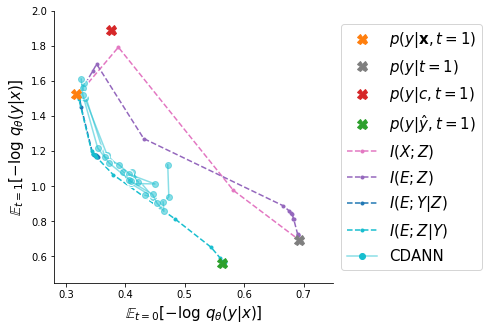

In [43]:
pd_r = pd.DataFrame(results)
pd_r = pd_r.sort_values('iterations')
f, ax = plt.subplots(1,1, figsize=(5,5))
sns.despine()

##for rid in pd_r['']
#pd_r.plot(x='CE(train_t0)',y='CE(train_t1)', ax=ax)
#decorate_plot(rm.datasets_info[dataset], ax)

legend_items = []

decorate_plot(rm.datasets_info[dataset],rm.style_info, ax, ['p(y|x,t=1)','p(y|t=1)','p(y|c,t=1)', 'p(y|d,t=1)', 
                                                            'I(X;Z)','I(E;Z)', 'I(E;Y|Z)', 'I(E;Z|Y)'])

min_max = {
    'ECI': {'min': 4000, 'max': 25000},
    'EI': {'min': 4000, 'max': 25000},
    'VIB': {'min': 4000, 'max': 30000},
    'VREx': {'min': 4000, 'max': 30000}
}

for rid in pd_r['rid'].unique():
    dataset, algorithm = rm.rid2datalg(rid)
    s_pd = pd_r[pd_r['rid']==rid]
    s_pd = s_pd[s_pd['iterations']>=min_max[algorithm]['min']]
    s_pd = s_pd[s_pd['iterations']<=min_max[algorithm]['max']]
    s_pd = s_pd.sort_values('iterations')
    params = rm.style_info[algorithm]['params']
    label = rm.style_info[algorithm]['name'] 
    
    if label!='CDANN':# and label!='VIB' :
        continue
    
    if label in legend_items:
        label = None
    else:
        legend_items.append(label)
    ax.plot(s_pd['CE(train_t0)'], s_pd['CE(test_t1)'], 'ow', markersize=8, alpha=1)
    ax.plot(s_pd['CE(train_t0)'], s_pd['CE(test_t1)'], **params, alpha=0.5, label=label)
    
handles, labels = ax.get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8]#,9,5,8,4,10]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

leg = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15,)
#leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
    
for i, lh in enumerate(leg.legendHandles): 
    if i< 4:
        lh.set_linewidth(0)
    lh._legmarker.set_alpha(1)

#ax.set_title(rm.datasets_info[dataset]['name'], size=20)
#ax.set_title('CMNIST ($e\\to \\hat y$)', size=20)

replace_labels = {
    '$p(y|x,t=1)$': '$p(y|{\\bf x},t=1)$',
    '$p(y|d,t=1)$': '$p(y|{\\hat y},t=1)$'
}

for text in leg.get_texts():
    label = text.get_text()
    if label in replace_labels:
        text.set_text(replace_labels[label])

In [71]:
data

,CE(test_t0),CE(test_t1),CE(train_t0),CE(train_t1),iterations,rid,algorithm
0,0.693435,0.693086,0.693443,0.693093,0,nnm8nmk3,CDANN
1,0.497574,0.809671,0.491867,0.812869,10681,nnm8nmk3,CDANN
2,0.545229,0.716965,0.548463,0.717727,12818,nnm8nmk3,CDANN
3,0.538564,0.693820,0.539034,0.687623,14954,nnm8nmk3,CDANN
4,0.545011,0.661967,0.541827,0.661436,17090,nnm8nmk3,CDANN
...,...,...,...,...,...,...,...
187,0.430431,1.335365,0.434010,1.330908,9400,85wm1r49,VIB
188,0.684366,0.721886,0.682433,0.720256,25850,85wm1r49,VIB
189,0.692768,0.699472,0.691357,0.700338,28200,85wm1r49,VIB
190,0.692604,0.695465,0.692549,0.695481,30550,85wm1r49,VIB


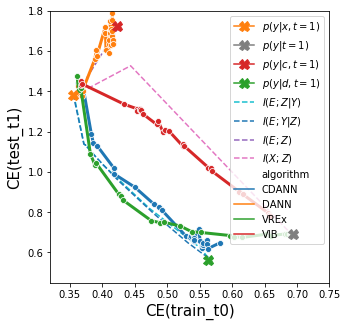

In [76]:
min_iterations = 4000
max_iterations = 25000

pd_data = pd.DataFrame(data)


pd_data = pd_data[pd_data['iterations']>min_iterations]
pd_data = pd_data[pd_data['iterations']<max_iterations]
f, ax = plt.subplots(1,1,figsize=(5,5))
decorate_plot(rm.datasets_info[dataset], ax)

sns.lineplot(data=pd_data, x='CE(train_t0)',y='CE(test_t1)', marker='o',linewidth=3, hue='algorithm')
ax.legend()

In [174]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [240]:
def make_animation(run, ax, x='CE(train_t0)', y='CE(test_t1)', n=10, color='b', samples=1000, max_steps=100000):
    
    print('Scanning history')
    h = run.history(samples=samples, pandas=False)
    
    data = [{'x':r[x], 
                 'y':r[y],
                 'step': r['_step']} for r in h if y in r]
    
    
    data = [{'x':r['x'], 
                 'y':r['y'],
                 'step': r['step']} for r in data if isinstance(r['x'], float) and isinstance(r['y'], float)]
   
    lines = []
    i = 0
    for k in range(n):
        idx = i-k
        idx_ = idx-1
        if idx<0:
            idx=0
        if idx_<0:
            idx_=0
        alpha = 1-(float(k+1.0)/(n+1.0))
        line, = ax.plot([], [], '.-', color=color, alpha=alpha)
        lines.append(line)
    
    # initialization function: plot the background of each frame
    def init():
        for k in range(n):
            idx = i-k
            idx_ = idx-1
            if idx<0:
                idx=0
            if idx_<0:
                idx_=0
            alpha = float(k+1.0)/(n+1.0)
            lines[k].set_data([data[idx_]['x'],data[idx]['x']], [data[idx_]['y'],data[idx]['y']])
            lines[k].set_alpha(alpha)
        return lines

    # animation function. This is called sequentially
    def animate(i):
        for k in range(n):
            idx = i-k
            idx_ = idx-1
            if idx<0:
                idx=0
            if idx_<0:
                idx_=0
            alpha = 1-(float(k+1.0)/(n+1.0))
            lines[k].set_data([data[idx_]['x'],data[idx]['x']], [data[idx_]['y'],data[idx]['y']])
            lines[k].set_alpha(alpha)
        return lines
    
    print('Animating')
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=min(len(data),max_steps), interval=50, blit=True)
    return anim

Not printing: I(E;Z|Y)
Scanning history
Animating


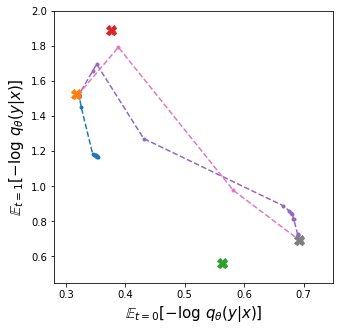

In [244]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1,1, figsize=(5,5))

decorate_plot(rm.datasets_info[dataset],rm.style_info, ax, plot_only=['I(X;Z)',
                                                                      'p(y|x,t=1)','p(y|t=1)', 'p(y|d,t=1)','p(y|c,t=1)','I(E;Z)','I(E;Y|Z)'])

anim = make_animation(runs[1], ax, n=5, color=rm.style_info[algorithm]['params']['color'], max_steps=400)

In [245]:
HTML(anim.to_html5_video())

In [34]:
# Old stuff